# Stock Picking using Optimizers

On this project, I'll analyse how to build the best portfolio of a given set of stocks. "Best" meaning that the portfolio has been optimized for the investor's fondness of risk.

This project has been organized in the following way:

1. __Importing/Manipulating Data__
2. __Exploratory Data Anlalysis__
3. __Portfolio Optimization__

## Importing / Manipulating Data

This data has been collected from the Yahoo Finance website. The first thing I'll do is to download all data and store it in a single dataframe.

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import spearmanr
import numpy as np
from math import sqrt
import seaborn as sns
from scipy.stats import norm
import scipy.optimize as spo

%matplotlib inline

In [18]:
def corr_matrix(dataframe):
    f, ax = plt.subplots(figsize=(10, 8))
    corr = dataframe.corr()
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax)

In [19]:
def var(data, confidence=0.95):
    mean = np.mean(data)
    std = np.std(data)
    return norm.ppf(confidence, mean, std)

After loading the data, I check for correlations on the daily swings for each stock. Some 'clusters' are easily identifiable only by looking at the correlation matrix. For example, all bank stocks seem to move together.

min_date: 2013-07-01
max_date: 2018-06-25


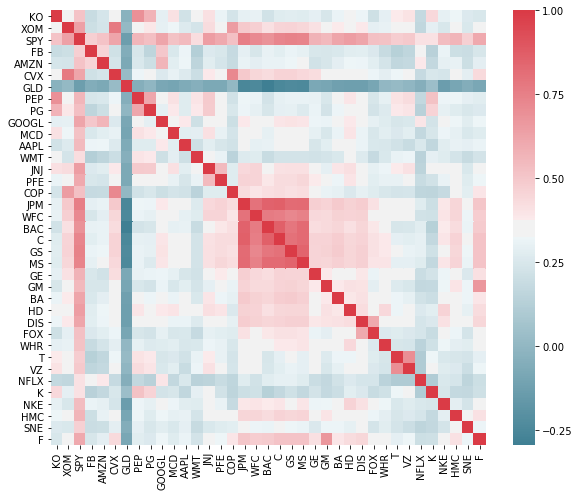

In [20]:
all_data = []
stocks = ['KO', 'XOM', 'SPY', 'FB', 'AMZN',
          'CVX', 'GLD', 'PEP', 'PG', 'GOOGL', 
          'MCD', 'AAPL', 'WMT', 'JNJ', 'PFE',
          'COP','JPM', 'WFC', 'BAC', 'C',
          'GS', 'MS', 'GE', 'GM', 'BA', 'HD',
          'DIS', 'FOX', 'WHR', 'T', 'VZ', 'NFLX',
              'K', 'NKE', 'HMC', 'SNE', 'F']

for stock in stocks:
    stock_data = pd.read_csv('/Users/guilhermeperticarari/Downloads/'+stock+'.csv', index_col='Date', usecols=['Date', 'Adj Close'])
    stock_data.rename({'Adj Close':stock}, inplace=True, axis='columns')
    if len(all_data) == 0:
        all_data = stock_data
    else:
        all_data = all_data.join(stock_data, how='inner')
        
all_data = all_data.reset_index()
all_data = all_data.sort_values(by='Date')

print('min_date: ' + str(all_data.Date.min()))
print('max_date: ' + str(all_data.Date.max()))

all_data = all_data.set_index('Date')

## Correlation of pct change in price

all_data_pct = all_data.pct_change()
corr_matrix(all_data_pct)

Now, I'll plot the cummulative gains for each individual stock. It's clear that, of all stocks on this study, Netflix is the best performing one. It has yielded a 12x return in 5 years when most stocks have yielded less than 2x.

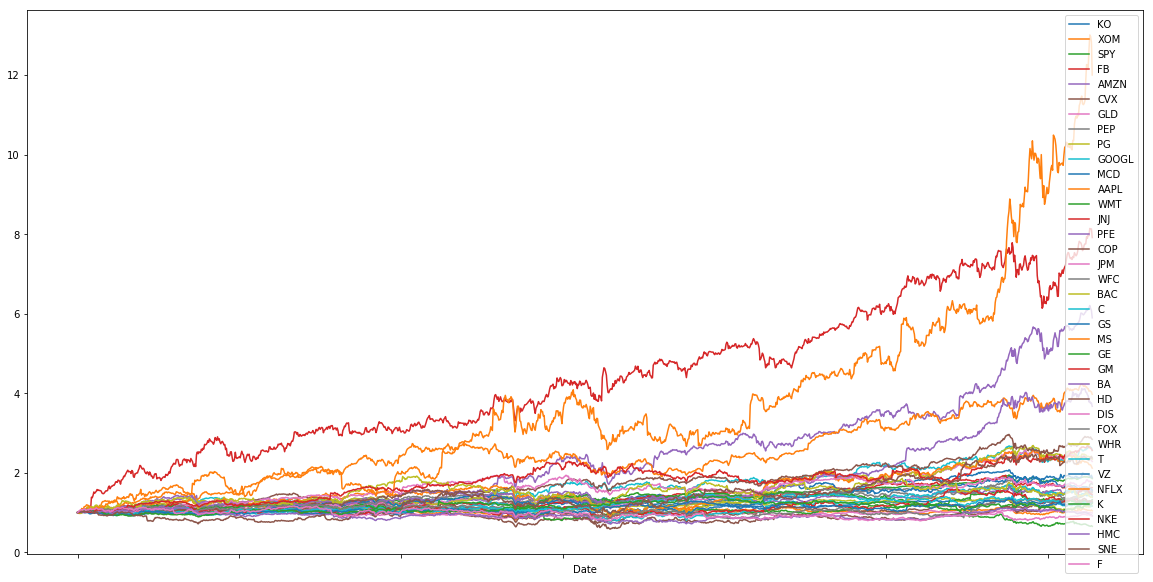

In [65]:
all_data_pct=all_data_pct.dropna()
norm_all = all_data/all_data.iloc[0,:]
fig, ax = plt.subplots(figsize=(20,10))
norm_all.plot(ax=ax)
plt.show()

This bar graph shows the 5-year cummulative returns for all stocks. Traditional companies, such as GE, Ford and Honda actually show a loss (less than 1x return) for the period.

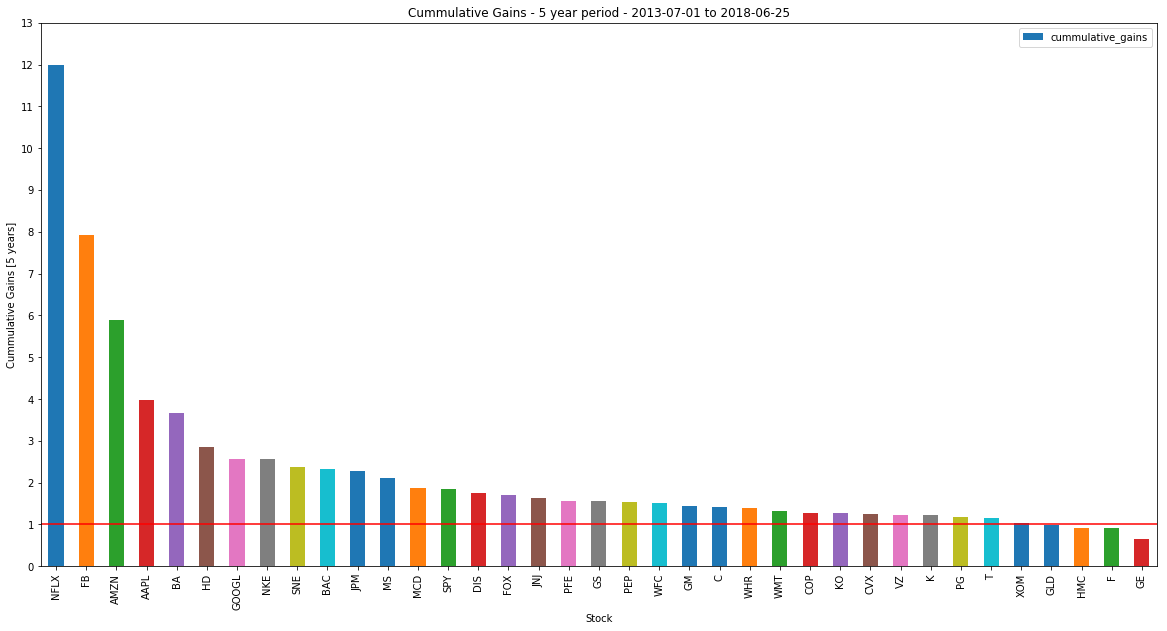

In [32]:
fig, ax = plt.subplots(figsize=(20,10))
cumm_gains = norm_all.iloc[-1, :].reset_index()
cumm_gains.columns = ['stock', 'cummulative_gains']
cumm_gains = cumm_gains.sort_values('cummulative_gains', ascending=False)
cumm_gains.plot(x='stock', y='cummulative_gains', kind='bar', ax=ax)
plt.title('Cummulative Gains - 5 year period - 2013-07-01 to 2018-06-25')
ax.set_yticks(np.arange(14))
plt.axhline(y=1, color='r', linestyle='-')
plt.xlabel('Stock')
plt.ylabel('Cummulative Gains [5 years]')
plt.show()

In [33]:
def daily_return(prices):
    return prices[1:].values / prices[:-1] - 1

VaR, or Value at Risk, is a metric of volatility. In simples words, it is a historical daily loss that we can expect for 95% or 99% of cases.

In [34]:
var_data = {'stock':[], 'var_95':[], 'var_99':[]}
for stock in stocks:
    daily = daily_return(all_data[stock])
    var_data['stock'].append(stock)
    var_data['var_95'].append(var(daily, confidence=0.95))
    var_data['var_99'].append(var(daily, confidence=0.99))
var_data = pd.DataFrame(var_data)
var_data = var_data.set_index('stock')

This graph shows that, while Netflix shows the best cummulative gain, it also has the worst VaR for both 95% and 99%. That means that people who are risk-averse should not put too much money on this individual stock.

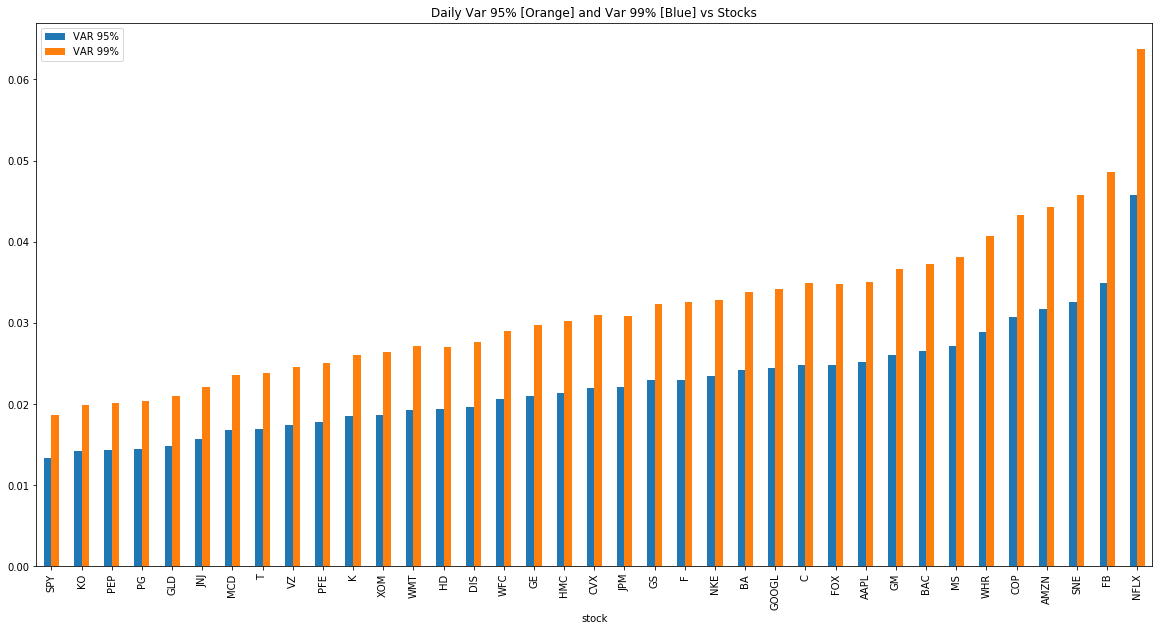

In [35]:
fig, ax = plt.subplots(figsize=(20,10))
var_data = var_data.sort_values(by='var_95')
var_data.plot(y=['var_95', 'var_99'], kind='bar', ax=ax, label=['VAR 95%', 'VAR 99%'])
plt.title('Daily Var 95% [Orange] and Var 99% [Blue] vs Stocks')
plt.show()

To get a better grasp of volatility, I've plotted the histogram for the most volatile stock (Netflix) and the least volatile (S&P 500 ETF). It is very clear that, if historical data is to be used as a guide for the future, NFLX will show more ups and downs than SPY.

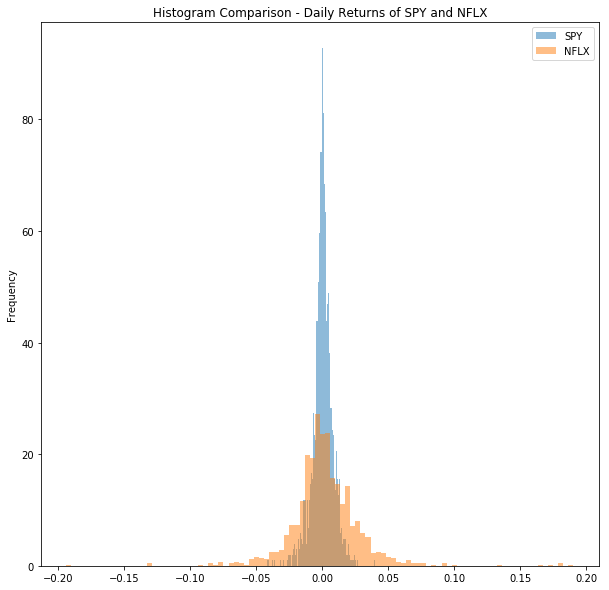

In [36]:
fig, ax = plt.subplots(figsize=(10,10))
daily_return(all_data.SPY).plot(ax=ax, kind='hist', bins=100, alpha=0.5, normed=1)
daily_return(all_data.NFLX).plot(ax=ax, kind='hist', bins=100, alpha=0.5, normed=1)
plt.legend()
plt.title('Histogram Comparison - Daily Returns of SPY and NFLX')
plt.show()

The fact that NFLX has the best cummultive gain but the worst risk is not a surprise. Actually, the risk/reward principle states that if we want to play it safe, we should not expect sky-rocketing gains (SPY), but if we are willing to lose some money, we might achieve very good rewards.

In [37]:
cumm_gains = cumm_gains.set_index('stock')

In [38]:
summ_statistics = cumm_gains.join(var_data)
for stock in stocks:
    summ_statistics.loc[stock, 'std'] = np.std(daily_return(all_data[stock]))
    summ_statistics.loc[stock, 'mean_ret'] = np.mean(daily_return(all_data[stock]))

This scatter plot is a very good picture of this principle. More risk = more volatility.

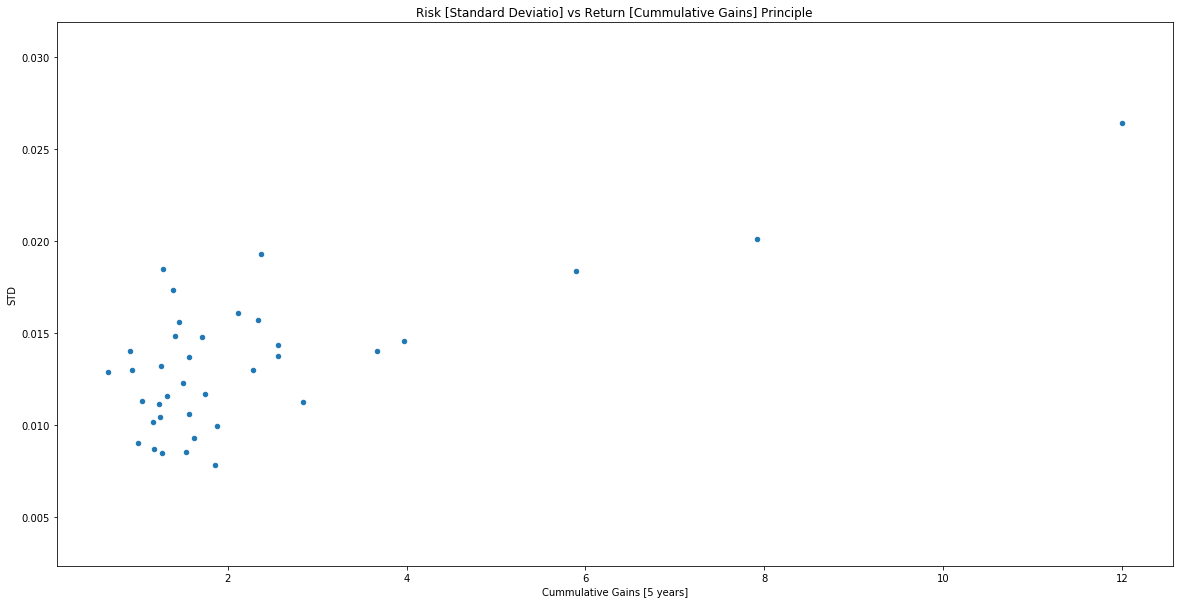

In [67]:
fig, ax = plt.subplots(figsize=(20,10))
summ_statistics.plot(x='cummulative_gains', y='std', kind='scatter', ax=ax)
plt.title('Risk [Standard Deviatio] vs Return [Cummulative Gains] Principle')
plt.xlabel('Cummulative Gains [5 years]')
plt.ylabel('STD')
plt.show()


## Sharpe Ratio and Other Statistics

The Sharpe Ratio is a metric that tries to analyze a stock not only for its gain but also for its volatility. It uses a 'risk-adjusted-gain' ratio for this:

__Sharpe Ratio of X = [Return of X - Return of Risk-Free Asset] / [Volatility of X - Volatility of Risk-Free Asset]__

Here, I will be using Return of Risk-Free Asset and Volatility of Risk-Free Asset as 0, which is mainly true for US bonds.

In [40]:
def get_sharpe(data):
    daily = daily_return(data) 
    return sqrt(252)*np.mean(daily)/np.std(daily)

In [41]:
for stock in stocks:
    summ_statistics.loc[stock, 'sharpe'] = get_sharpe(all_data[stock])

In [42]:
summ_statistics.sort_values(by='sharpe', ascending=False).head()

,cummulative_gains,var_95,var_99,std,mean_ret,sharpe
stock,,,,,,
FB,7.914148,0.034936,0.048647,0.020118,0.001845,1.455843
NFLX,12.000000,0.045791,0.063800,0.026424,0.002327,1.398098
AMZN,5.895604,0.031758,0.044260,0.018346,0.001582,1.368622
AAPL,3.972281,0.025158,0.035082,0.014562,0.001206,1.314250
BA,3.670509,0.024192,0.033745,0.014018,0.001135,1.285312


It's clear that, although Netflix has the best returns, it's Facebook that shows the best Sharpe Ratio, since it's dramatically less volatile than NFLX.

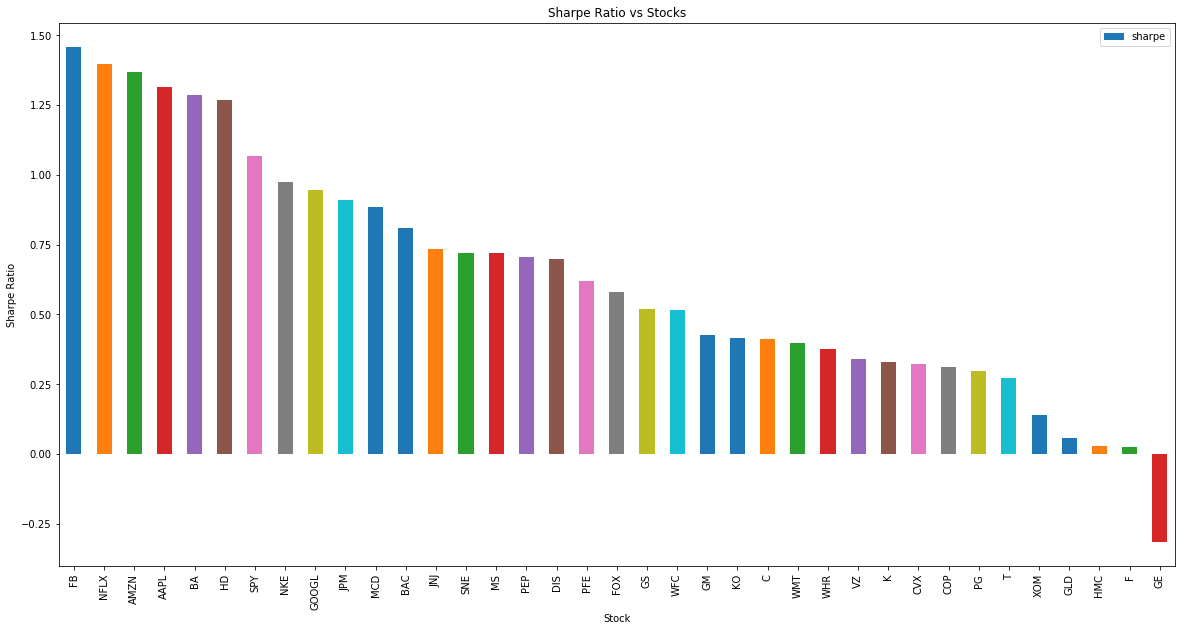

In [43]:
fig, ax = plt.subplots(figsize=(20,10))
summ_statistics.sort_values(by='sharpe', ascending=False).plot(y='sharpe', kind='bar', ax=ax)
plt.title('Sharpe Ratio vs Stocks')
plt.xlabel('Stock')
plt.ylabel('Sharpe Ratio')
plt.show()

## Portfolio Allocation

Before optimizing, I will build three functions that will be used by the optimizers. One of them returns the cummulative gain for a given portfolio, the other returns teh std and the last one returns the Sharpe Ratio.

In [47]:
def port_cumm_gain(weights):
    portfolio_norm = weights*norm_all
    return -1*portfolio_norm.sum(axis=1).iloc[-1]

def port_sharpe(weights):
    portfolio_norm = weights*norm_all
    return -1*get_sharpe(portfolio_norm.sum(axis=1))

def port_std(weights):
    portfolio_norm = (weights*norm_all).sum(axis=1)
    return np.std(portfolio_norm)

def get_port(weights):
    return (norm_all*weights).sum(axis=1)

### Optimizing for Volatility

When we optimize a portfolio for volatility, without taking gain into consideration, the result will be a set os stocks that do not move much, neither up nor down. This portfolio is probably a very bad idea, since any bond or SPY stock would be safer and more profitable.

Std Deviation: 0.02467059013970057
Sharpe Ratio: 0.123511060329
Cumm Gain: 1.03726918712


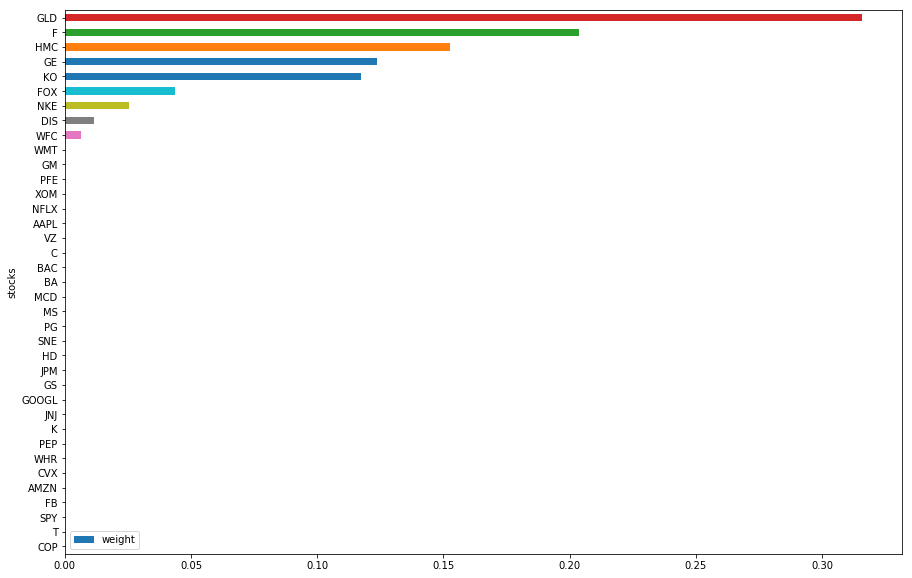

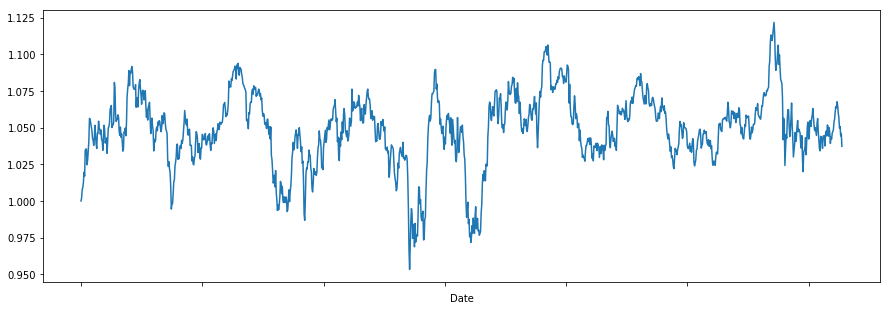

In [62]:
bounds = [(0,1) for i in range(len(weights))]
cons = [{'type':'eq', 'fun': lambda x: np.sum(x)-1}]
res = spo.minimize(port_std, weights, method='SLSQP', bounds=bounds, constraints=cons)
weights_dict = {'stocks':stocks, 'weight':res.x}
print('Std Deviation:', res.fun)
print('Sharpe Ratio:', np.abs(port_sharpe(res.x)))
print('Cumm Gain:', np.abs(port_cumm_gain(res.x)))
fig, ax = plt.subplots(figsize=(15,10))
pd.DataFrame(weights_dict).sort_values(by='weight').plot(x='stocks', y='weight', kind='barh', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(15,5))
get_port(res.x).plot(ax=ax)
plt.show()

### Optimizing for the Cummulative Gain

This optimization is the most trivial one, since the best portfolio would basically be an 'all-in' position for the best performing stock. This optimization makes no sense for any future analysis, since we're not taking into account risk in any measure.

Std Deviation: 2.36601722167
Sharpe Ratio: 1.39809784103
Cumm Gain: 11.9999999688


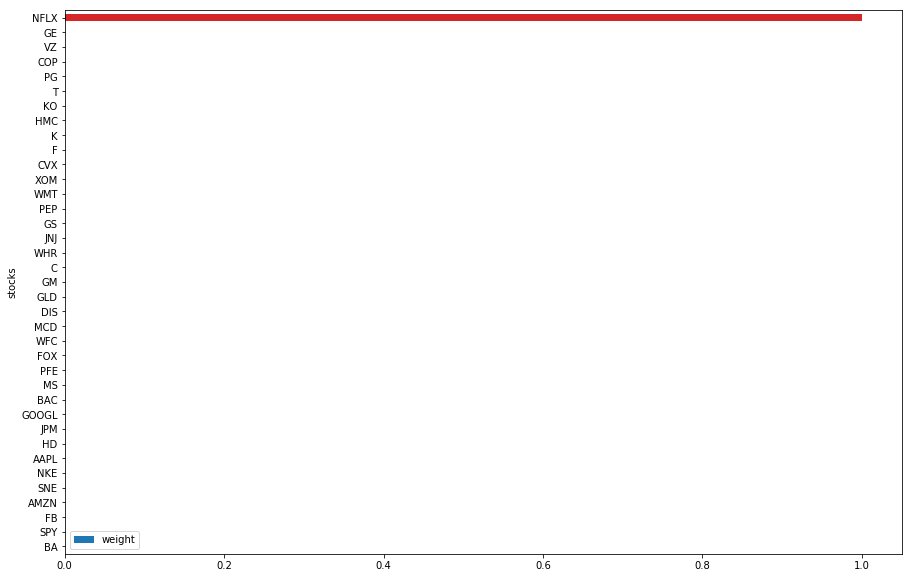

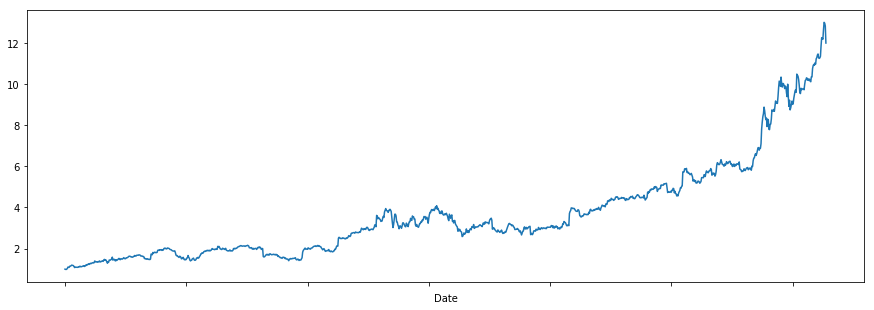

In [63]:
bounds = [(0,1) for i in range(len(weights))]
cons = [{'type':'eq', 'fun': lambda x: np.sum(x)-1}]
res = spo.minimize(port_cumm_gain, weights, method='SLSQP', bounds=bounds, constraints=cons)
weights_dict = {'stocks':stocks, 'weight':res.x}

print('Std Deviation:', np.abs(port_std(res.x)))
print('Sharpe Ratio:', np.abs(port_sharpe(res.x)))
print('Cumm Gain:', np.abs(port_cumm_gain(res.x)))

fig, ax = plt.subplots(figsize=(15,10))
pd.DataFrame(weights_dict).sort_values(by='weight').plot(x='stocks', y='weight', kind='barh', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(15,5))
get_port(res.x).plot(ax=ax)
plt.show()

### Optimizing for Sharpe Ratio

Now, I will find the best portfolio in terms of sharpe ratio. Of all three, this seems to be the best portfolio, since its cummulative gains are very good (5x in 5 years) and the volatility, given by the std, is not so bad. This is the result of using a metric that takes into considerationg both volatility and cummulative gain.

Std Deviation: 1.00051316248
Sharpe Ratio: 1.93033033119
Cumm Gain: 5.05272226674


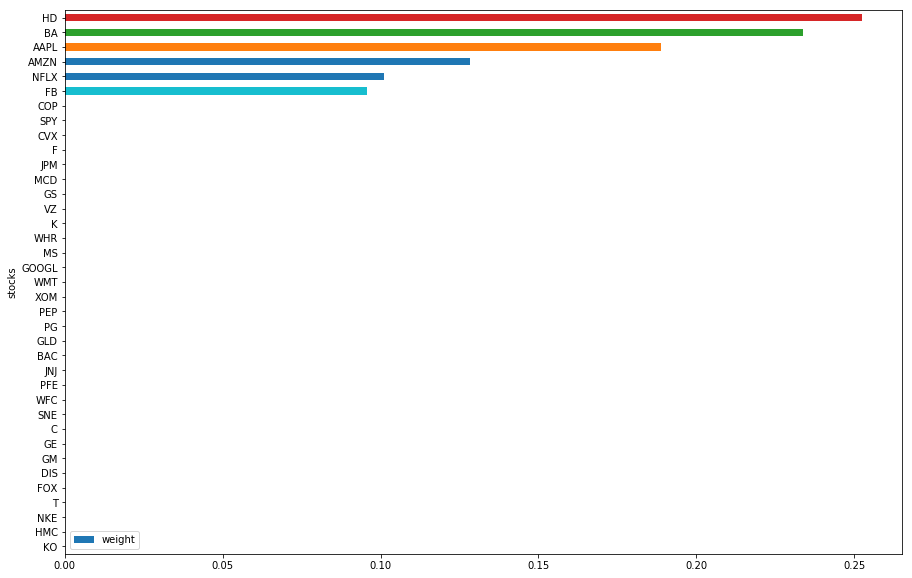

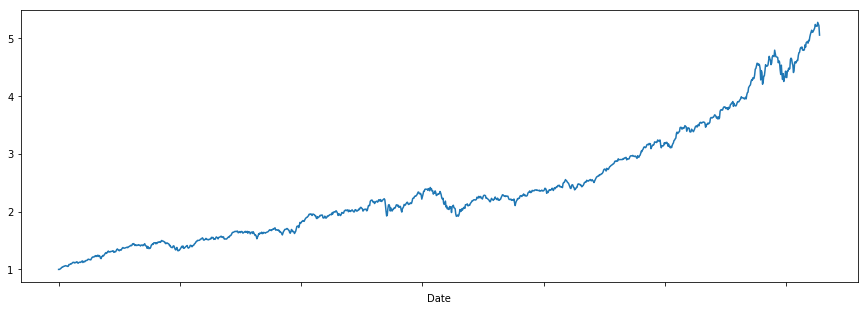

In [64]:
bounds = [(0,1) for i in range(len(weights))]
cons = [{'type':'eq', 'fun': lambda x: np.sum(np.abs(x))-1}]
res = spo.minimize(port_sharpe, weights, method='SLSQP', bounds=bounds, constraints=cons)
weights_dict = {'stocks':stocks, 'weight':res.x}

print('Std Deviation:', np.abs(port_std(res.x)))
print('Sharpe Ratio:', np.abs(port_sharpe(res.x)))
print('Cumm Gain:', np.abs(port_cumm_gain(res.x)))

fig, ax = plt.subplots(figsize=(15,10))
pd.DataFrame(weights_dict).sort_values(by='weight').plot(x='stocks', y='weight', kind='barh', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(15,5))
get_port(res.x).plot(ax=ax)
plt.show()